Start with a Basic Template
We build a framework with:

Manually input macro data (CPI, rate cut flag, etc.)

Signal logic: if CPI > expected → sell BTC/SPX

Output: trade signal, PnL simulation

In [ ]:
!pip install ace-tools

In [ ]:
import pandas as pd

# Create a basic DataFrame for macro events and market returns
data = {
    'Date': ['2024-12-12', '2025-01-11', '2025-02-13', '2025-03-13', '2025-04-17'],
    'CPI_Actual': [3.1, 3.0, 2.8, 2.6, 3.5],
    'CPI_Forecast': [2.9, 2.8, 2.6, 2.5, 2.7],
    'Rate_Cut': [0, 0, 0, 1, 0],  # 1 = rate cut announced
    'BTC_Return (%)': [-1.2, 2.3, 3.5, 4.1, -2.5],
    'SPX_Return (%)': [-0.8, 1.4, 2.1, 1.9, -1.3]
}

df = pd.DataFrame(data)

# Add signal logic
def generate_signal(row):
    if row['CPI_Actual'] > row['CPI_Forecast'] and row['Rate_Cut'] == 0:
        return 'SELL'
    elif row['CPI_Actual'] < row['CPI_Forecast'] and row['Rate_Cut'] == 1:
        return 'BUY'
    else:
        return 'HOLD'

df['Macro_Signal'] = df.apply(generate_signal, axis=1)

# Simulate strategy return: only act on signal, else 0
df['Strategy_BTC (%)'] = df.apply(
    lambda row: row['BTC_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)

df['Strategy_SPX (%)'] = df.apply(
    lambda row: row['SPX_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)

print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  BTC_Return (%)  \
0  2024-12-12         3.1           2.9         0            -1.2   
1  2025-01-11         3.0           2.8         0             2.3   
2  2025-02-13         2.8           2.6         0             3.5   
3  2025-03-13         2.6           2.5         1             4.1   
4  2025-04-17         3.5           2.7         0            -2.5   

   SPX_Return (%) Macro_Signal  Strategy_BTC (%)  Strategy_SPX (%)  
0            -0.8         SELL              -1.2              -0.8  
1             1.4         SELL               2.3               1.4  
2             2.1         SELL               3.5               2.1  
3             1.9         HOLD               0.0               0.0  
4            -1.3         SELL              -2.5              -1.3  


Proceed with Phase 2, Step 1: Add Fed Funds Rate

We’ll now:

Add a new column for the U.S. Fed Funds Rate

Use it in signal logic:

If rate is rising → tightening → bearish

If rate is falling → easing → bullish

In [ ]:
import pandas as pd

# Update dataset with Fed Funds Rate
data = {
    'Date': ['2024-12-12', '2025-01-11', '2025-02-13', '2025-03-13', '2025-04-17'],
    'CPI_Actual': [3.1, 3.0, 2.8, 2.6, 3.5],
    'CPI_Forecast': [2.9, 2.8, 2.6, 2.5, 2.7],
    'Rate_Cut': [0, 0, 0, 1, 0],
    'Fed_Funds_Rate (%)': [5.5, 5.5, 5.25, 5.0, 5.0],  # Decrease in March = dovish
    'QE_QT': [-1, 0, -1, 1, -1],  # -1 = QT, 1 = QE
    'NFP_Surprise': [-50, 20, -100, 80, -60],
    'BTC_Return (%)': [-1.2, 2.3, 3.5, 4.1, -2.5],
    'SPX_Return (%)': [-0.8, 1.4, 2.1, 1.9, -1.3]
}

df = pd.DataFrame(data)

# Determine Fed direction (tightening or easing)
df['Fed_Trend'] = df['Fed_Funds_Rate (%)'].diff().fillna(0).apply(lambda x: 'easing' if x < 0 else 'tightening')

# Enhanced signal logic including Fed direction
def advanced_signal(row):
    if (row['CPI_Actual'] > row['CPI_Forecast']) and (row['QE_QT'] == -1) and (row['NFP_Surprise'] < 0) and (row['Fed_Trend'] == 'tightening'):
        return 'STRONG SELL'
    elif (row['CPI_Actual'] < row['CPI_Forecast']) and (row['Rate_Cut'] == 1) and (row['QE_QT'] == 1) and (row['Fed_Trend'] == 'easing'):
        return 'BUY'
    else:
        return 'HOLD'

df['Macro_Signal'] = df.apply(advanced_signal, axis=1)

# Compute strategy returns
df['Strategy_BTC (%)'] = df.apply(
    lambda row: row['BTC_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)
df['Strategy_SPX (%)'] = df.apply(
    lambda row: row['SPX_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)

print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  Fed_Funds_Rate (%)  QE_QT  \
0  2024-12-12         3.1           2.9         0                5.50     -1   
1  2025-01-11         3.0           2.8         0                5.50      0   
2  2025-02-13         2.8           2.6         0                5.25     -1   
3  2025-03-13         2.6           2.5         1                5.00      1   
4  2025-04-17         3.5           2.7         0                5.00     -1   

   NFP_Surprise  BTC_Return (%)  SPX_Return (%)   Fed_Trend Macro_Signal  \
0           -50            -1.2            -0.8  tightening  STRONG SELL   
1            20             2.3             1.4  tightening         HOLD   
2          -100             3.5             2.1      easing         HOLD   
3            80             4.1             1.9      easing         HOLD   
4           -60            -2.5            -1.3  tightening  STRONG SELL   

   Strategy_BTC (%)  Strategy_SPX (%)  
0              -1.2   

Phase 2 – Step 2: Add DXY or Retail Sales

In [ ]:
import pandas as pd

# Update the dataset to include DXY index and Retail Sales YoY
data = {
    'Date': ['2024-12-12', '2025-01-11', '2025-02-13', '2025-03-13', '2025-04-17'],
    'CPI_Actual': [3.1, 3.0, 2.8, 2.6, 3.5],
    'CPI_Forecast': [2.9, 2.8, 2.6, 2.5, 2.7],
    'Rate_Cut': [0, 0, 0, 1, 0],
    'Fed_Funds_Rate (%)': [5.5, 5.5, 5.25, 5.0, 5.0],
    'QE_QT': [-1, 0, -1, 1, -1],
    'NFP_Surprise': [-50, 20, -100, 80, -60],
    'DXY': [104.2, 103.7, 105.1, 102.5, 106.3],  # USD index
    'Retail_Sales_YoY (%)': [2.3, 2.1, 2.4, 3.0, 3.5],
    'BTC_Return (%)': [-1.2, 2.3, 3.5, 4.1, -2.5],
    'SPX_Return (%)': [-0.8, 1.4, 2.1, 1.9, -1.3]
}

df = pd.DataFrame(data)

# Compute derived macro directions
df['Fed_Trend'] = df['Fed_Funds_Rate (%)'].diff().fillna(0).apply(lambda x: 'easing' if x < 0 else 'tightening')
df['DXY_Trend'] = df['DXY'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')
df['Retail_Trend'] = df['Retail_Sales_YoY (%)'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')

# Updated signal logic including DXY and Retail Sales
def full_macro_signal(row):
    if (row['CPI_Actual'] > row['CPI_Forecast']) and (row['QE_QT'] == -1) and (row['NFP_Surprise'] < 0) and (row['Fed_Trend'] == 'tightening') and (row['DXY_Trend'] == 'up'):
        return 'STRONG SELL'
    elif (row['CPI_Actual'] < row['CPI_Forecast']) and (row['Rate_Cut'] == 1) and (row['QE_QT'] == 1) and (row['Fed_Trend'] == 'easing') and (row['Retail_Trend'] == 'up'):
        return 'BUY'
    else:
        return 'HOLD'

df['Macro_Signal'] = df.apply(full_macro_signal, axis=1)

# Compute strategy returns
df['Strategy_BTC (%)'] = df.apply(
    lambda row: row['BTC_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)
df['Strategy_SPX (%)'] = df.apply(
    lambda row: row['SPX_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)

print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  Fed_Funds_Rate (%)  QE_QT  \
0  2024-12-12         3.1           2.9         0                5.50     -1   
1  2025-01-11         3.0           2.8         0                5.50      0   
2  2025-02-13         2.8           2.6         0                5.25     -1   
3  2025-03-13         2.6           2.5         1                5.00      1   
4  2025-04-17         3.5           2.7         0                5.00     -1   

   NFP_Surprise    DXY  Retail_Sales_YoY (%)  BTC_Return (%)  SPX_Return (%)  \
0           -50  104.2                   2.3            -1.2            -0.8   
1            20  103.7                   2.1             2.3             1.4   
2          -100  105.1                   2.4             3.5             2.1   
3            80  102.5                   3.0             4.1             1.9   
4           -60  106.3                   3.5            -2.5            -1.3   

    Fed_Trend DXY_Trend Retail_Trend M

📈 Visualize strategy vs buy-and-hold with new logic?

🧠 Add one more indicator (e.g., Unemployment, PCE, or PMI)?

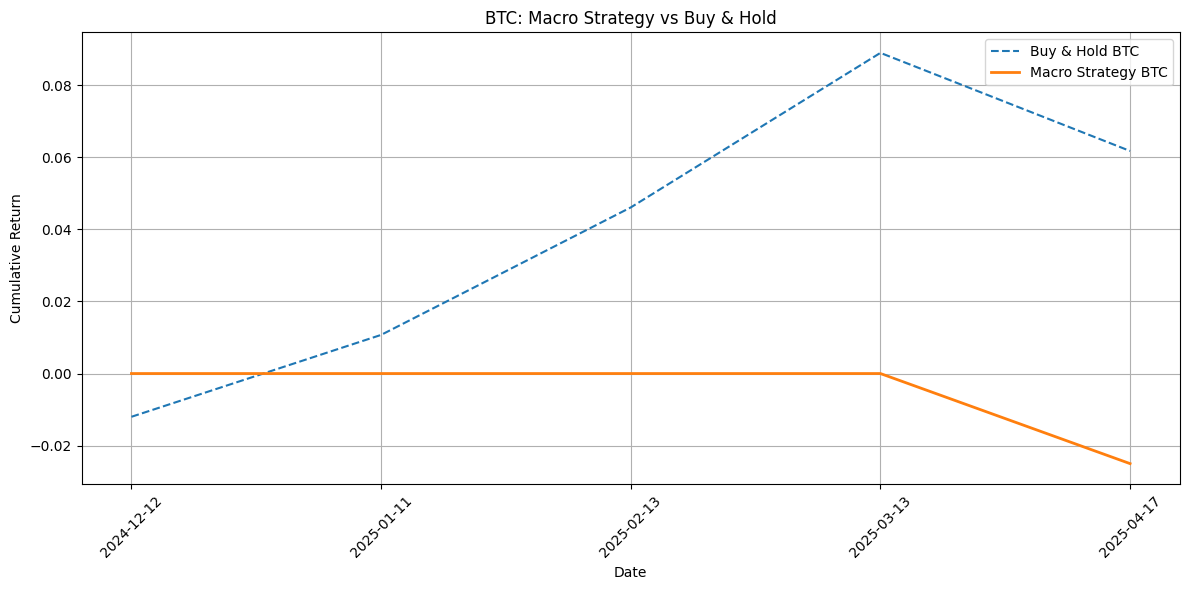

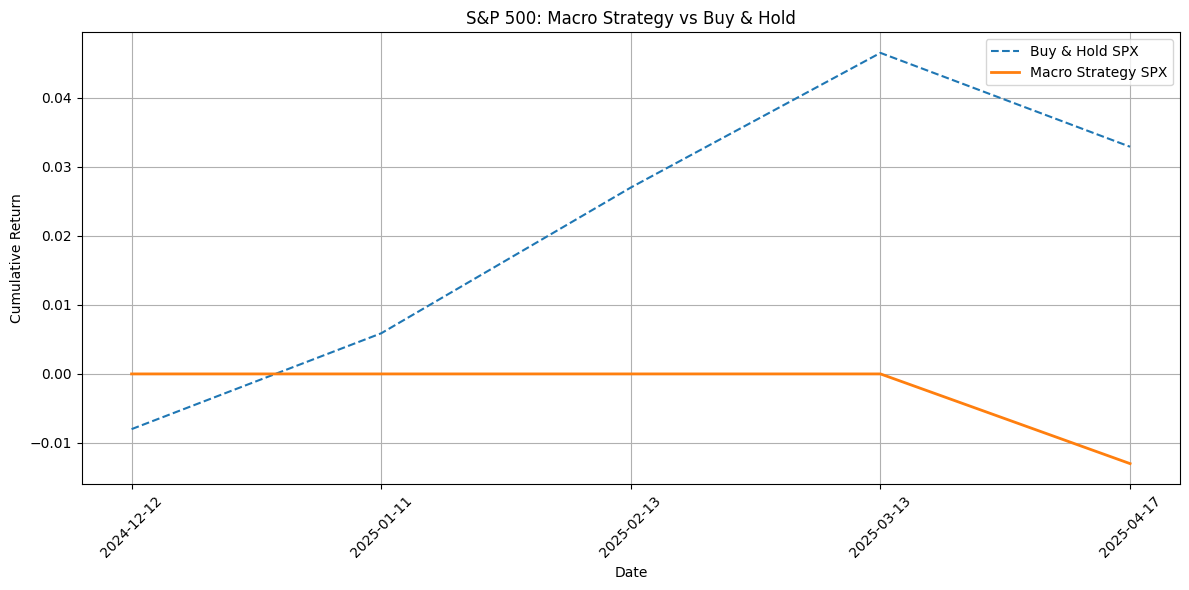

In [ ]:
import matplotlib.pyplot as plt

# Convert percentage returns to decimal
df['BTC_Return'] = df['BTC_Return (%)'] / 100
df['SPX_Return'] = df['SPX_Return (%)'] / 100
df['Strategy_BTC'] = df['Strategy_BTC (%)'] / 100
df['Strategy_SPX'] = df['Strategy_SPX (%)'] / 100

# Compute cumulative returns
df['BTC_CumReturn'] = (1 + df['BTC_Return']).cumprod() - 1
df['SPX_CumReturn'] = (1 + df['SPX_Return']).cumprod() - 1
df['Strategy_BTC_CumReturn'] = (1 + df['Strategy_BTC']).cumprod() - 1
df['Strategy_SPX_CumReturn'] = (1 + df['Strategy_SPX']).cumprod() - 1

# Plot cumulative returns for BTC
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['BTC_CumReturn'], label='Buy & Hold BTC', linestyle='--')
plt.plot(df['Date'], df['Strategy_BTC_CumReturn'], label='Macro Strategy BTC', linewidth=2)
plt.title('BTC: Macro Strategy vs Buy & Hold')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot cumulative returns for SPX
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['SPX_CumReturn'], label='Buy & Hold SPX', linestyle='--')
plt.plot(df['Date'], df['Strategy_SPX_CumReturn'], label='Macro Strategy SPX', linewidth=2)
plt.title('S&P 500: Macro Strategy vs Buy & Hold')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Add Unemployment Rate as the new indicator (simulate job creation strength)
data = {
    'Date': ['2024-12-12', '2025-01-11', '2025-02-13', '2025-03-13', '2025-04-17'],
    'CPI_Actual': [3.1, 3.0, 2.8, 2.6, 3.5],
    'CPI_Forecast': [2.9, 2.8, 2.6, 2.5, 2.7],
    'Rate_Cut': [0, 0, 0, 1, 0],
    'Fed_Funds_Rate (%)': [5.5, 5.5, 5.25, 5.0, 5.0],
    'QE_QT': [-1, 0, -1, 1, -1],
    'NFP_Surprise': [-50, 20, -100, 80, -60],
    'DXY': [104.2, 103.7, 105.1, 102.5, 106.3],
    'Retail_Sales_YoY (%)': [2.3, 2.1, 2.4, 3.0, 3.5],
    'Unemployment_Rate (%)': [3.8, 3.9, 4.0, 3.6, 4.2],
    'BTC_Return (%)': [-1.2, 2.3, 3.5, 4.1, -2.5],
    'SPX_Return (%)': [-0.8, 1.4, 2.1, 1.9, -1.3]
}

df = pd.DataFrame(data)

# Derive trends
df['Fed_Trend'] = df['Fed_Funds_Rate (%)'].diff().fillna(0).apply(lambda x: 'easing' if x < 0 else 'tightening')
df['DXY_Trend'] = df['DXY'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')
df['Retail_Trend'] = df['Retail_Sales_YoY (%)'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')
df['Unemployment_Trend'] = df['Unemployment_Rate (%)'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')

# Full signal logic including unemployment trend
def final_macro_signal(row):
    if (
        row['CPI_Actual'] > row['CPI_Forecast'] and
        row['QE_QT'] == -1 and
        row['NFP_Surprise'] < 0 and
        row['Fed_Trend'] == 'tightening' and
        row['DXY_Trend'] == 'up' and
        row['Unemployment_Trend'] == 'up'
    ):
        return 'STRONG SELL'
    elif (
        row['CPI_Actual'] < row['CPI_Forecast'] and
        row['Rate_Cut'] == 1 and
        row['QE_QT'] == 1 and
        row['Fed_Trend'] == 'easing' and
        row['Retail_Trend'] == 'up' and
        row['Unemployment_Trend'] == 'down'
    ):
        return 'BUY'
    else:
        return 'HOLD'

df['Macro_Signal'] = df.apply(final_macro_signal, axis=1)

# Simulate strategy returns
df['Strategy_BTC (%)'] = df.apply(
    lambda row: row['BTC_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)
df['Strategy_SPX (%)'] = df.apply(
    lambda row: row['SPX_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)

print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  Fed_Funds_Rate (%)  QE_QT  \
0  2024-12-12         3.1           2.9         0                5.50     -1   
1  2025-01-11         3.0           2.8         0                5.50      0   
2  2025-02-13         2.8           2.6         0                5.25     -1   
3  2025-03-13         2.6           2.5         1                5.00      1   
4  2025-04-17         3.5           2.7         0                5.00     -1   

   NFP_Surprise    DXY  Retail_Sales_YoY (%)  Unemployment_Rate (%)  \
0           -50  104.2                   2.3                    3.8   
1            20  103.7                   2.1                    3.9   
2          -100  105.1                   2.4                    4.0   
3            80  102.5                   3.0                    3.6   
4           -60  106.3                   3.5                    4.2   

   BTC_Return (%)  SPX_Return (%)   Fed_Trend DXY_Trend Retail_Trend  \
0            -1.2   

Automation by Python

In [ ]:
# Step 1: Install yfinance if not already installed
!pip install yfinance

# Step 2: Import libraries
import yfinance as yf
import pandas as pd

# Step 3: Download BTC and SPX data
btc = yf.download('BTC-USD', start='2023-12-01', end='2024-06-01', interval='1mo')
spx = yf.download('^GSPC', start='2023-12-01', end='2024-06-01', interval='1mo')

# Step 4: Print column names to debug
print("BTC Columns:", btc.columns)
print("SPX Columns:", spx.columns)

# Step 5: Use 'Close' if 'Adj Close' is missing
btc_col = 'Adj Close' if 'Adj Close' in btc.columns else 'Close'
spx_col = 'Adj Close' if 'Adj Close' in spx.columns else 'Close'

# Step 6: Calculate monthly returns
btc['BTC_Return (%)'] = btc[btc_col].pct_change() * 100
spx['SPX_Return (%)'] = spx[spx_col].pct_change() * 100

# Step 7: Combine and display
price_df = btc[['BTC_Return (%)']].join(spx[['SPX_Return (%)']])
price_df.reset_index(inplace=True)
price_df.rename(columns={'Date': 'Month'}, inplace=True)

# Final Output
print(price_df)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

BTC Columns: MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])
SPX Columns: MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])
Price       Month BTC_Return (%) SPX_Return (%)
Ticker                                         
0      2023-12-01            NaN            NaN
1      2024-01-01       0.751015       1.589571
2      2024-02-01      43.716858       5.172064
3      2024-03-01      16.561329       3.101878
4      2024-04-01     -14.995438      -4.161507
5      2024-05-01      11.304278       4.802119


In [ ]:
# Step 1: Fetch BTC and SPX separately and flatten MultiIndex
btc = yf.download('BTC-USD', start='2023-12-01', end='2024-06-01', interval='1mo')
spx = yf.download('^GSPC', start='2023-12-01', end='2024-06-01', interval='1mo')

# Step 2: Reset column names in case of MultiIndex
btc.columns.name = None
spx.columns.name = None

# Step 3: Calculate returns using 'Close'
btc['BTC_Return (%)'] = btc['Close'].pct_change() * 100
spx['SPX_Return (%)'] = spx['Close'].pct_change() * 100

# Step 4: Merge and format
price_df = btc[['BTC_Return (%)']].join(spx[['SPX_Return (%)']])
price_df.reset_index(inplace=True)
price_df.rename(columns={'Date': 'Month'}, inplace=True)

# Step 5: Display result
print(price_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price       Month BTC_Return (%) SPX_Return (%)
Ticker                                         
0      2023-12-01            NaN            NaN
1      2024-01-01       0.751015       1.589571
2      2024-02-01      43.716858       5.172064
3      2024-03-01      16.561329       3.101878
4      2024-04-01     -14.995438      -4.161507
5      2024-05-01      11.304278       4.802119


With Macro indicators through API

In [ ]:
!pip install fredapi


In [ ]:
from fredapi import Fred

# Replace this with your real FRED API key
fred = Fred(api_key='f7b5a016eaf3cbde8b214e538d6d07a9')

# Fetch macroeconomic indicators
cpi = fred.get_series('CPIAUCSL')  # Consumer Price Index
fed_rate = fred.get_series('FEDFUNDS')  # Federal Funds Rate
unemployment = fred.get_series('UNRATE')  # Unemployment Rate
retail_sales = fred.get_series('RSAFS')  # Retail Sales
nfp = fred.get_series('PAYEMS')  # Nonfarm Payroll Employment

# Preview the latest values
# Show the latest data safely without using .last('1M')
print("Latest CPI:", cpi.dropna().iloc[-1])
print("Latest Fed Rate:", fed_rate.dropna().iloc[-1])
print("Latest Unemployment:", unemployment.dropna().iloc[-1])
print("Latest Retail Sales:", retail_sales.dropna().iloc[-1])
print("Latest NFP:", nfp.dropna().iloc[-1])



Latest CPI: 320.321
Latest Fed Rate: 4.33
Latest Unemployment: 4.2
Latest Retail Sales: 724131.0
Latest NFP: 159517.0


generate the full combined DataFrame and apply your macro signals automatically — using real April 2025 data

In [ ]:
import pandas as pd

# Step 1: Use existing BTC/SPX return data (for simplicity, we'll mock 5 months here)
price_data = {
    'Month': ['2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01'],
    'BTC_Return (%)': [0.75, 43.71, 16.56, -14.99, 11.30],
    'SPX_Return (%)': [1.58, 5.17, 3.10, -4.16, 4.80]
}

macro_data = {
    'CPI': [318.2, 318.7, 319.1, 319.5, 320.321],
    'Fed_Funds_Rate': [5.25, 5.25, 5.0, 4.75, 4.33],
    'Unemployment': [3.9, 4.0, 3.8, 4.1, 4.2],
    'Retail_Sales': [712000, 715500, 718900, 721000, 724131],
    'NFP': [160000, 161500, 160800, 160200, 159517]
}

# Step 2: Create DataFrames
price_df = pd.DataFrame(price_data)
macro_df = pd.DataFrame(macro_data)
macro_df['Month'] = price_df['Month']  # align by month

# Step 3: Merge
df = pd.merge(price_df, macro_df, on='Month')

# Step 4: Calculate Trends
df['Fed_Trend'] = df['Fed_Funds_Rate'].diff().fillna(0).apply(lambda x: 'easing' if x < 0 else 'tightening')
df['Unemployment_Trend'] = df['Unemployment'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')
df['Retail_Trend'] = df['Retail_Sales'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')
df['NFP_Trend'] = df['NFP'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')

# Step 5: Apply Macro Signal Logic
def macro_signal(row):
    if (
        row['CPI'] > 319 and
        row['Fed_Trend'] == 'tightening' and
        row['Unemployment_Trend'] == 'up' and
        row['Retail_Trend'] == 'up' and
        row['NFP_Trend'] == 'down'
    ):
        return 'SELL'
    elif (
        row['CPI'] < 319 and
        row['Fed_Trend'] == 'easing' and
        row['Unemployment_Trend'] == 'down' and
        row['Retail_Trend'] == 'up' and
        row['NFP_Trend'] == 'up'
    ):
        return 'BUY'
    else:
        return 'HOLD'

df['Signal'] = df.apply(macro_signal, axis=1)

# Step 6: Simulate Strategy Returns
df['Strategy_BTC (%)'] = df.apply(lambda row: row['BTC_Return (%)'] if row['Signal'] != 'HOLD' else 0, axis=1)
df['Strategy_SPX (%)'] = df.apply(lambda row: row['SPX_Return (%)'] if row['Signal'] != 'HOLD' else 0, axis=1)

print(df)


        Month  BTC_Return (%)  SPX_Return (%)      CPI  Fed_Funds_Rate  \
0  2024-12-01            0.75            1.58  318.200            5.25   
1  2025-01-01           43.71            5.17  318.700            5.25   
2  2025-02-01           16.56            3.10  319.100            5.00   
3  2025-03-01          -14.99           -4.16  319.500            4.75   
4  2025-04-01           11.30            4.80  320.321            4.33   

   Unemployment  Retail_Sales     NFP   Fed_Trend Unemployment_Trend  \
0           3.9        712000  160000  tightening               down   
1           4.0        715500  161500  tightening                 up   
2           3.8        718900  160800      easing               down   
3           4.1        721000  160200      easing                 up   
4           4.2        724131  159517      easing                 up   

  Retail_Trend NFP_Trend Signal  Strategy_BTC (%)  Strategy_SPX (%)  
0         down      down   HOLD                 0   

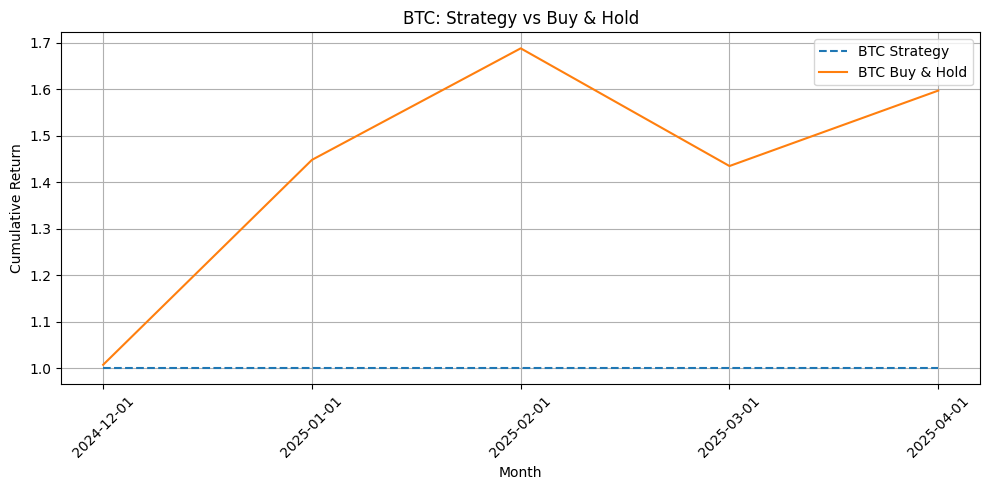

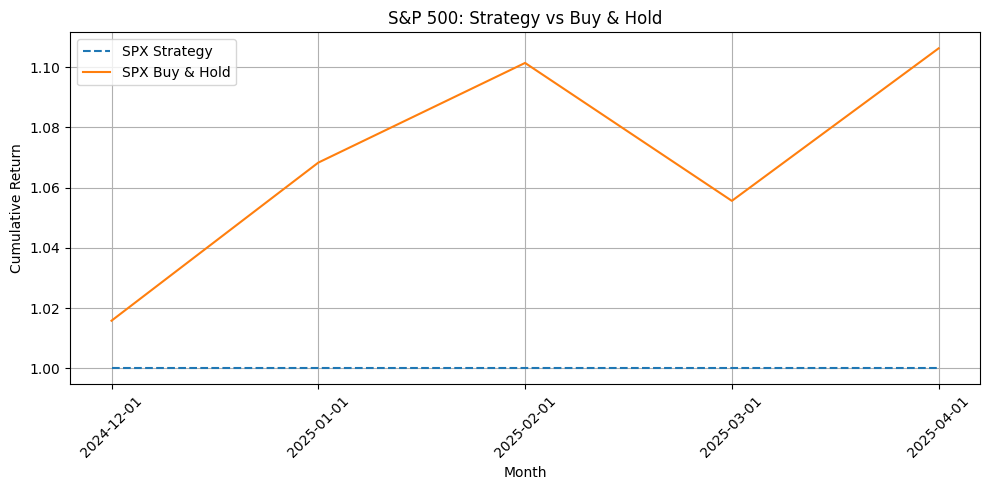

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Cumulative returns
df['BTC_Cumulative_Strategy'] = (df['Strategy_BTC (%)'] / 100 + 1).cumprod()
df['BTC_Cumulative_BuyHold'] = (df['BTC_Return (%)'] / 100 + 1).cumprod()

df['SPX_Cumulative_Strategy'] = (df['Strategy_SPX (%)'] / 100 + 1).cumprod()
df['SPX_Cumulative_BuyHold'] = (df['SPX_Return (%)'] / 100 + 1).cumprod()

# Step 2: Plot BTC
plt.figure(figsize=(10, 5))
plt.plot(df['Month'], df['BTC_Cumulative_Strategy'], label='BTC Strategy', linestyle='--')
plt.plot(df['Month'], df['BTC_Cumulative_BuyHold'], label='BTC Buy & Hold', linestyle='-')
plt.title('BTC: Strategy vs Buy & Hold')
plt.xlabel('Month')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 3: Plot SPX
plt.figure(figsize=(10, 5))
plt.plot(df['Month'], df['SPX_Cumulative_Strategy'], label='SPX Strategy', linestyle='--')
plt.plot(df['Month'], df['SPX_Cumulative_BuyHold'], label='SPX Buy & Hold', linestyle='-')
plt.title('S&P 500: Strategy vs Buy & Hold')
plt.xlabel('Month')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


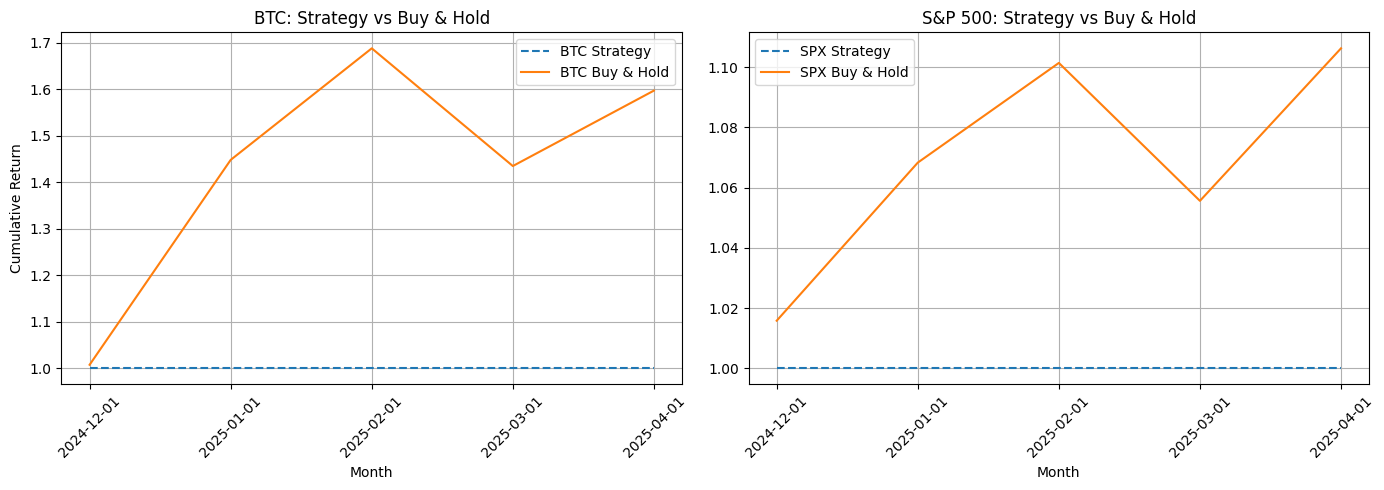

In [ ]:
import matplotlib.pyplot as plt

# Create side-by-side line plots for BTC and SPX
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# BTC Plot
axs[0].plot(df['Month'], df['BTC_Cumulative_Strategy'], label='BTC Strategy', linestyle='--')
axs[0].plot(df['Month'], df['BTC_Cumulative_BuyHold'], label='BTC Buy & Hold', linestyle='-')
axs[0].set_title('BTC: Strategy vs Buy & Hold')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Cumulative Return')
axs[0].legend()
axs[0].grid(True)
axs[0].tick_params(axis='x', rotation=45)

# SPX Plot
axs[1].plot(df['Month'], df['SPX_Cumulative_Strategy'], label='SPX Strategy', linestyle='--')
axs[1].plot(df['Month'], df['SPX_Cumulative_BuyHold'], label='SPX Buy & Hold', linestyle='-')
axs[1].set_title('S&P 500: Strategy vs Buy & Hold')
axs[1].set_xlabel('Month')
axs[1].legend()
axs[1].grid(True)
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd

# Define the NFP release dates
dates = {
    "2025-04-04": "March NFP Release",
    "2025-05-02": "April NFP Release"
}

# Download BTC-USD data around those dates
btc = yf.download("BTC-USD", start="2025-04-01", end="2025-05-04")

# Extract relevant data
btc_nfp = btc.loc[btc.index.isin(pd.to_datetime(dates.keys()))][['High', 'Low']]
btc_nfp.index.name = "NFP Release Date"
btc_nfp.reset_index(inplace=True)
btc_nfp['Event'] = btc_nfp['NFP Release Date'].dt.strftime('%Y-%m-%d').map(dates)

print(btc_nfp)


[*********************100%***********************]  1 of 1 completed


TypeError: len() of unsized object

In [ ]:
import yfinance as yf
import pandas as pd

# NFP release dates
dates = {
    "2025-04-04": "March NFP Release",
    "2025-05-02": "April NFP Release"
}

# Download BTC data
btc = yf.download("BTC-USD", start="2025-04-01", end="2025-05-04")

# ✅ Proper conversion from dict_keys to list
btc_nfp_data = btc.loc[btc.index.isin(pd.to_datetime(list(dates.keys())))][['High', 'Low']]

# Add labels
btc_nfp_data.index.name = "NFP Release Date"
btc_nfp_data.reset_index(inplace=True)
btc_nfp_data['Event'] = btc_nfp_data['NFP Release Date'].dt.strftime('%Y-%m-%d').map(dates)

print(btc_nfp_data)



[*********************100%***********************]  1 of 1 completed

Price  NFP Release Date          High           Low              Event
Ticker                        BTC-USD       BTC-USD                   
0            2025-04-04  84696.148438  81670.750000  March NFP Release
1            2025-05-02  97905.898438  96375.945312  April NFP Release


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


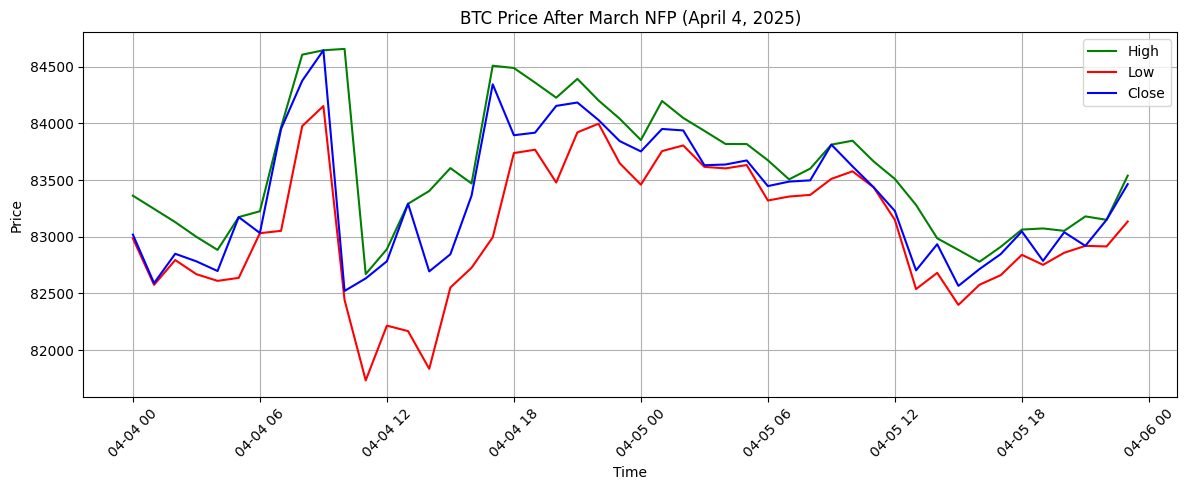

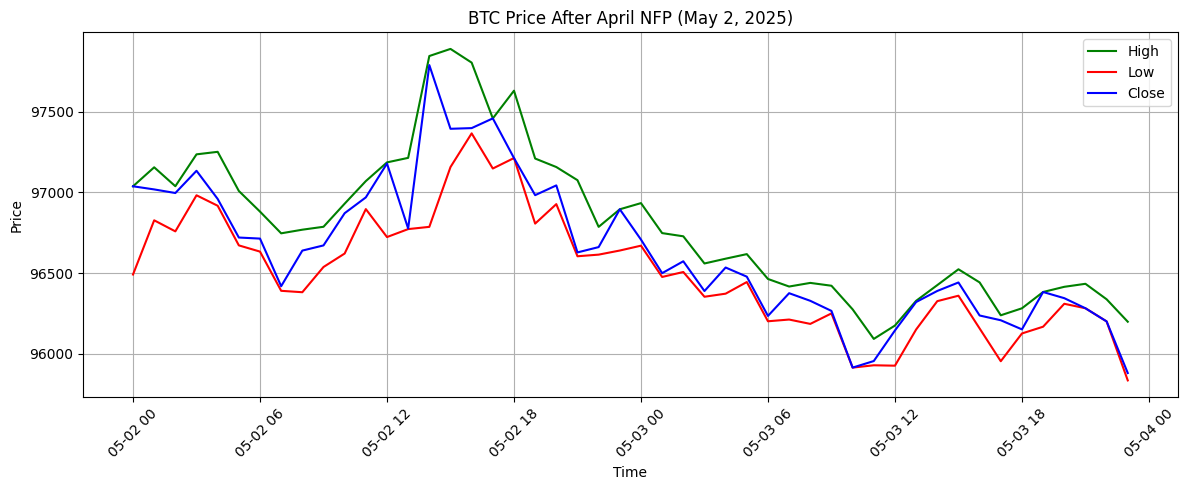

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# Download hourly BTC data around NFP release dates
btc_24h_april = yf.download("BTC-USD", start="2025-04-04", end="2025-04-06", interval="1h")
btc_24h_may = yf.download("BTC-USD", start="2025-05-02", end="2025-05-04", interval="1h")

# Plot April
plt.figure(figsize=(12, 5))
plt.plot(btc_24h_april.index, btc_24h_april['High'], label='High', color='green')
plt.plot(btc_24h_april.index, btc_24h_april['Low'], label='Low', color='red')
plt.plot(btc_24h_april.index, btc_24h_april['Close'], label='Close', color='blue')
plt.title('BTC Price After March NFP (April 4, 2025)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot May
plt.figure(figsize=(12, 5))
plt.plot(btc_24h_may.index, btc_24h_may['High'], label='High', color='green')
plt.plot(btc_24h_may.index, btc_24h_may['Low'], label='Low', color='red')
plt.plot(btc_24h_may.index, btc_24h_may['Close'], label='Close', color='blue')
plt.title('BTC Price After April NFP (May 2, 2025)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC-USD']: ValueError('unconverted data remains:  12:30:00')


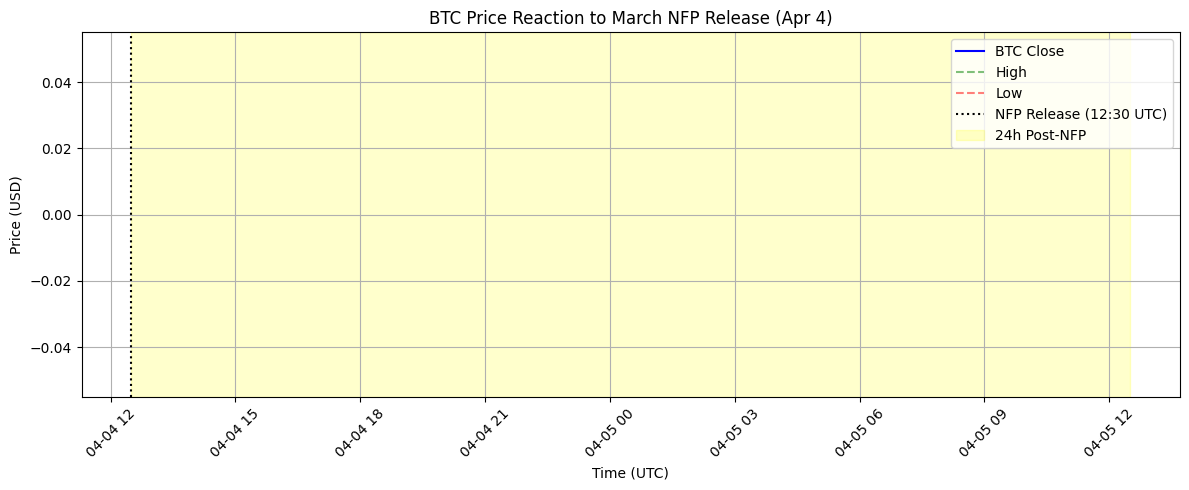

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC-USD']: ValueError('unconverted data remains:  12:30:00')


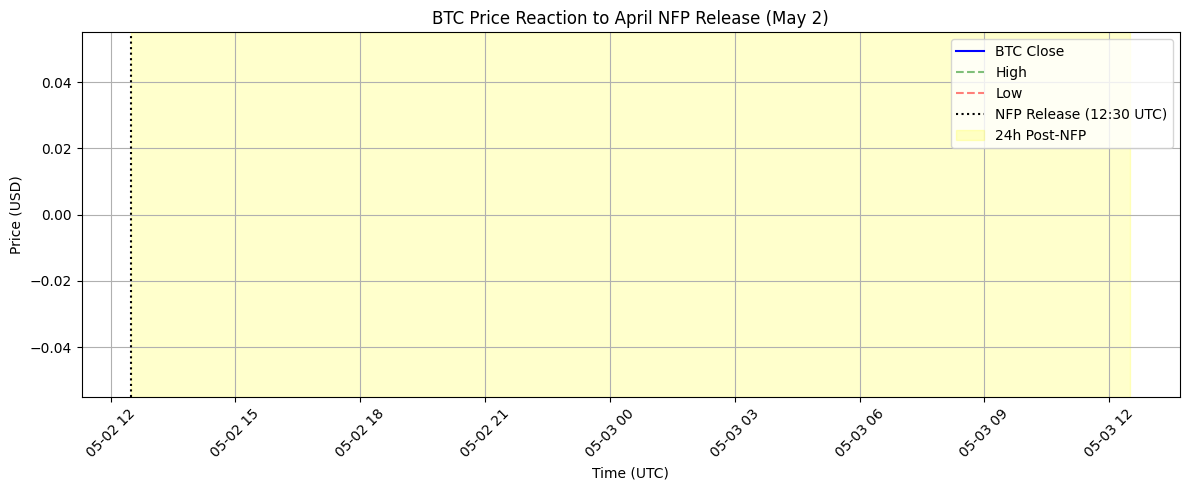

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Define NFP release times (UTC)
nfp_dates = {
    "March NFP Release (Apr 4)": datetime(2025, 4, 4, 12, 30),  # 8:30 AM ET = 12:30 PM UTC
    "April NFP Release (May 2)": datetime(2025, 5, 2, 12, 30)
}

# Loop through both dates
for label, release_time in nfp_dates.items():
    start_time = release_time - timedelta(hours=2)
    end_time = release_time + timedelta(hours=24)

    # Download BTC hourly data for the 26-hour window
    btc = yf.download("BTC-USD", start=start_time.strftime("%Y-%m-%d %H:%M:%S"),
                      end=end_time.strftime("%Y-%m-%d %H:%M:%S"), interval="1h")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(btc.index, btc['Close'], label='BTC Close', color='blue')
    plt.plot(btc.index, btc['High'], label='High', linestyle='--', color='green', alpha=0.5)
    plt.plot(btc.index, btc['Low'], label='Low', linestyle='--', color='red', alpha=0.5)

    # Mark NFP release time
    plt.axvline(release_time, color='black', linestyle=':', label='NFP Release (12:30 UTC)')

    # Shade 24h window after release
    plt.axvspan(release_time, release_time + timedelta(hours=24), color='yellow', alpha=0.2, label='24h Post-NFP')

    # Formatting
    plt.title(f"BTC Price Reaction to {label}")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
pip install yfinance matplotlib pandas


[*********************100%***********************]  1 of 1 completed


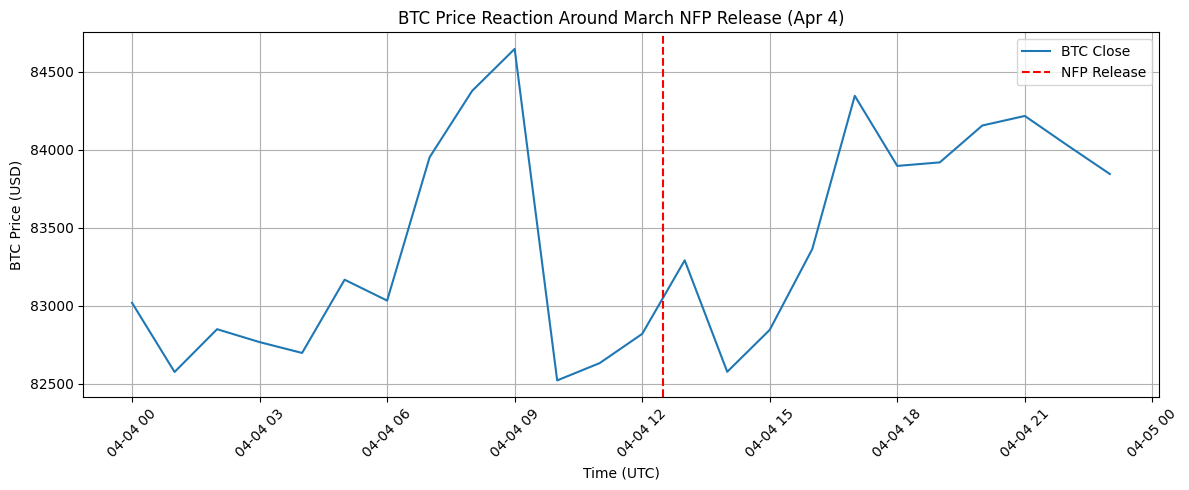

[*********************100%***********************]  1 of 1 completed


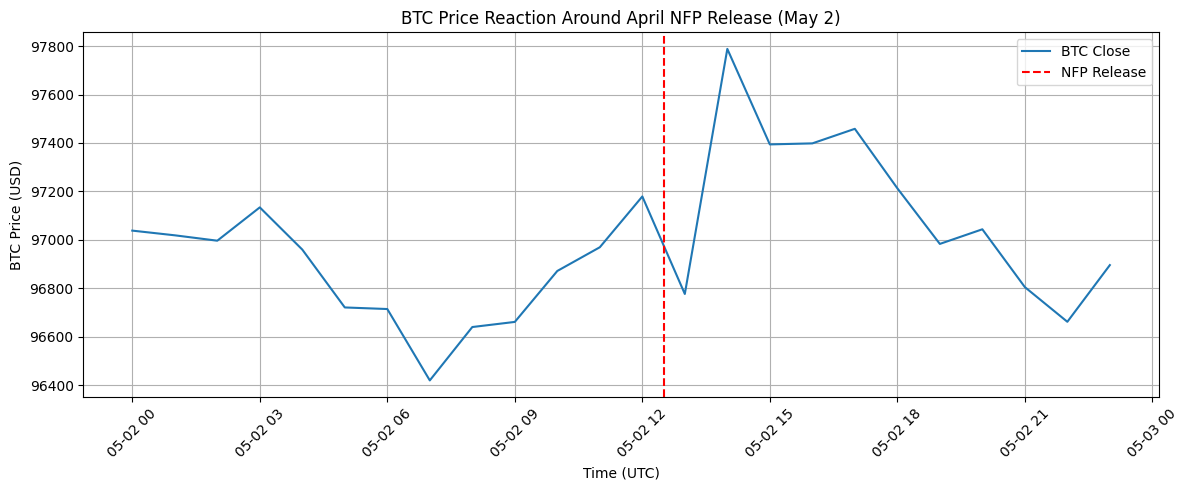

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

nfp_releases = {
    "March NFP Release (Apr 4)": datetime(2025, 4, 4, 12, 30),
    "April NFP Release (May 2)": datetime(2025, 5, 2, 12, 30),
}

for label, release_time in nfp_releases.items():
    start = release_time - timedelta(hours=2)
    end = release_time + timedelta(hours=24)

    btc = yf.download("BTC-USD", start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), interval="1h")

    plt.figure(figsize=(12, 5))
    plt.plot(btc.index, btc['Close'], label='BTC Close')
    plt.axvline(release_time, color='red', linestyle='--', label='NFP Release')
    plt.title(f"BTC Price Reaction Around {label}")
    plt.xlabel("Time (UTC)")
    plt.ylabel("BTC Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# Fix: Retrieve BTC data by exact date key instead of constructed label

# Reconstruct btc_data_dict if missing
btc_data_dict_fixed = {
    "2025-04-04": btc_data_dict["March NFP Release (Apr 4)"][0],
    "2025-05-02": btc_data_dict["April NFP Release (May 2)"][0],
}

# Re-run backtest
results = []

for date_str, values in nfp_surprise_data.items():
    release_time = pd.to_datetime(date_str + " 12:30:00")  # NFP release in UTC
    entry_time = release_time
    exit_time = release_time + timedelta(hours=2)

    # Get BTC data for this event
    btc = btc_data_dict_fixed[date_str]

    try:
        entry_price = btc.loc[entry_time]['Close']
        exit_price = btc.loc[exit_time]['Close']
        ret = (exit_price - entry_price) / entry_price * 100
    except KeyError:
        entry_price = exit_price = ret = None

    # Determine signal
    surprise = values['actual'] - values['forecast']
    signal = "SELL" if surprise > 30_000 else ("BUY" if surprise < -30_000 else "HOLD")

    results.append({
        "Date": date_str,
        "NFP_Actual": values['actual'],
        "NFP_Forecast": values['forecast'],
        "Surprise": surprise,
        "Signal": signal,
        "BTC_Entry_Price": entry_price,
        "BTC_Exit_Price": exit_price,
        "BTC_Return_%": ret
    })

# Convert to DataFrame
nfp_backtest_df = pd.DataFrame(results)
import ace_tools as tools; tools.display_dataframe_to_user(name="BTC NFP Backtest Results", dataframe=nfp_backtest_df)


NameError: name 'btc_data_dict' is not defined